# Example: Partial Kepler long-cadence light curve of Kepler-572

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams; rcParams["figure.dpi"] = 250
import numpy as np
import lightkurve as lk

### Data and Simple preprocessing

In [2]:
search_result = lk.search_lightcurve(f'Kepler-572',author='Kepler',cadence='long',quarter=5)
lc = search_result.download().remove_nans()
t0 = np.array(lc.time.value) 
f0 = np.array(lc.flux.value) 
df0 = np.array(lc.flux_err.value)
good_idx = np.where(lc.quality==0)[0] 
t0 = t0[good_idx] 
f0 = f0[good_idx] 
df0 = df0[good_idx] 
index_sort = np.argsort(t0)
t = t0[index_sort]
f1 = f0[index_sort]
df1 = df0[index_sort]
f = f1/np.median(f1)
df = df1/np.median(f1)

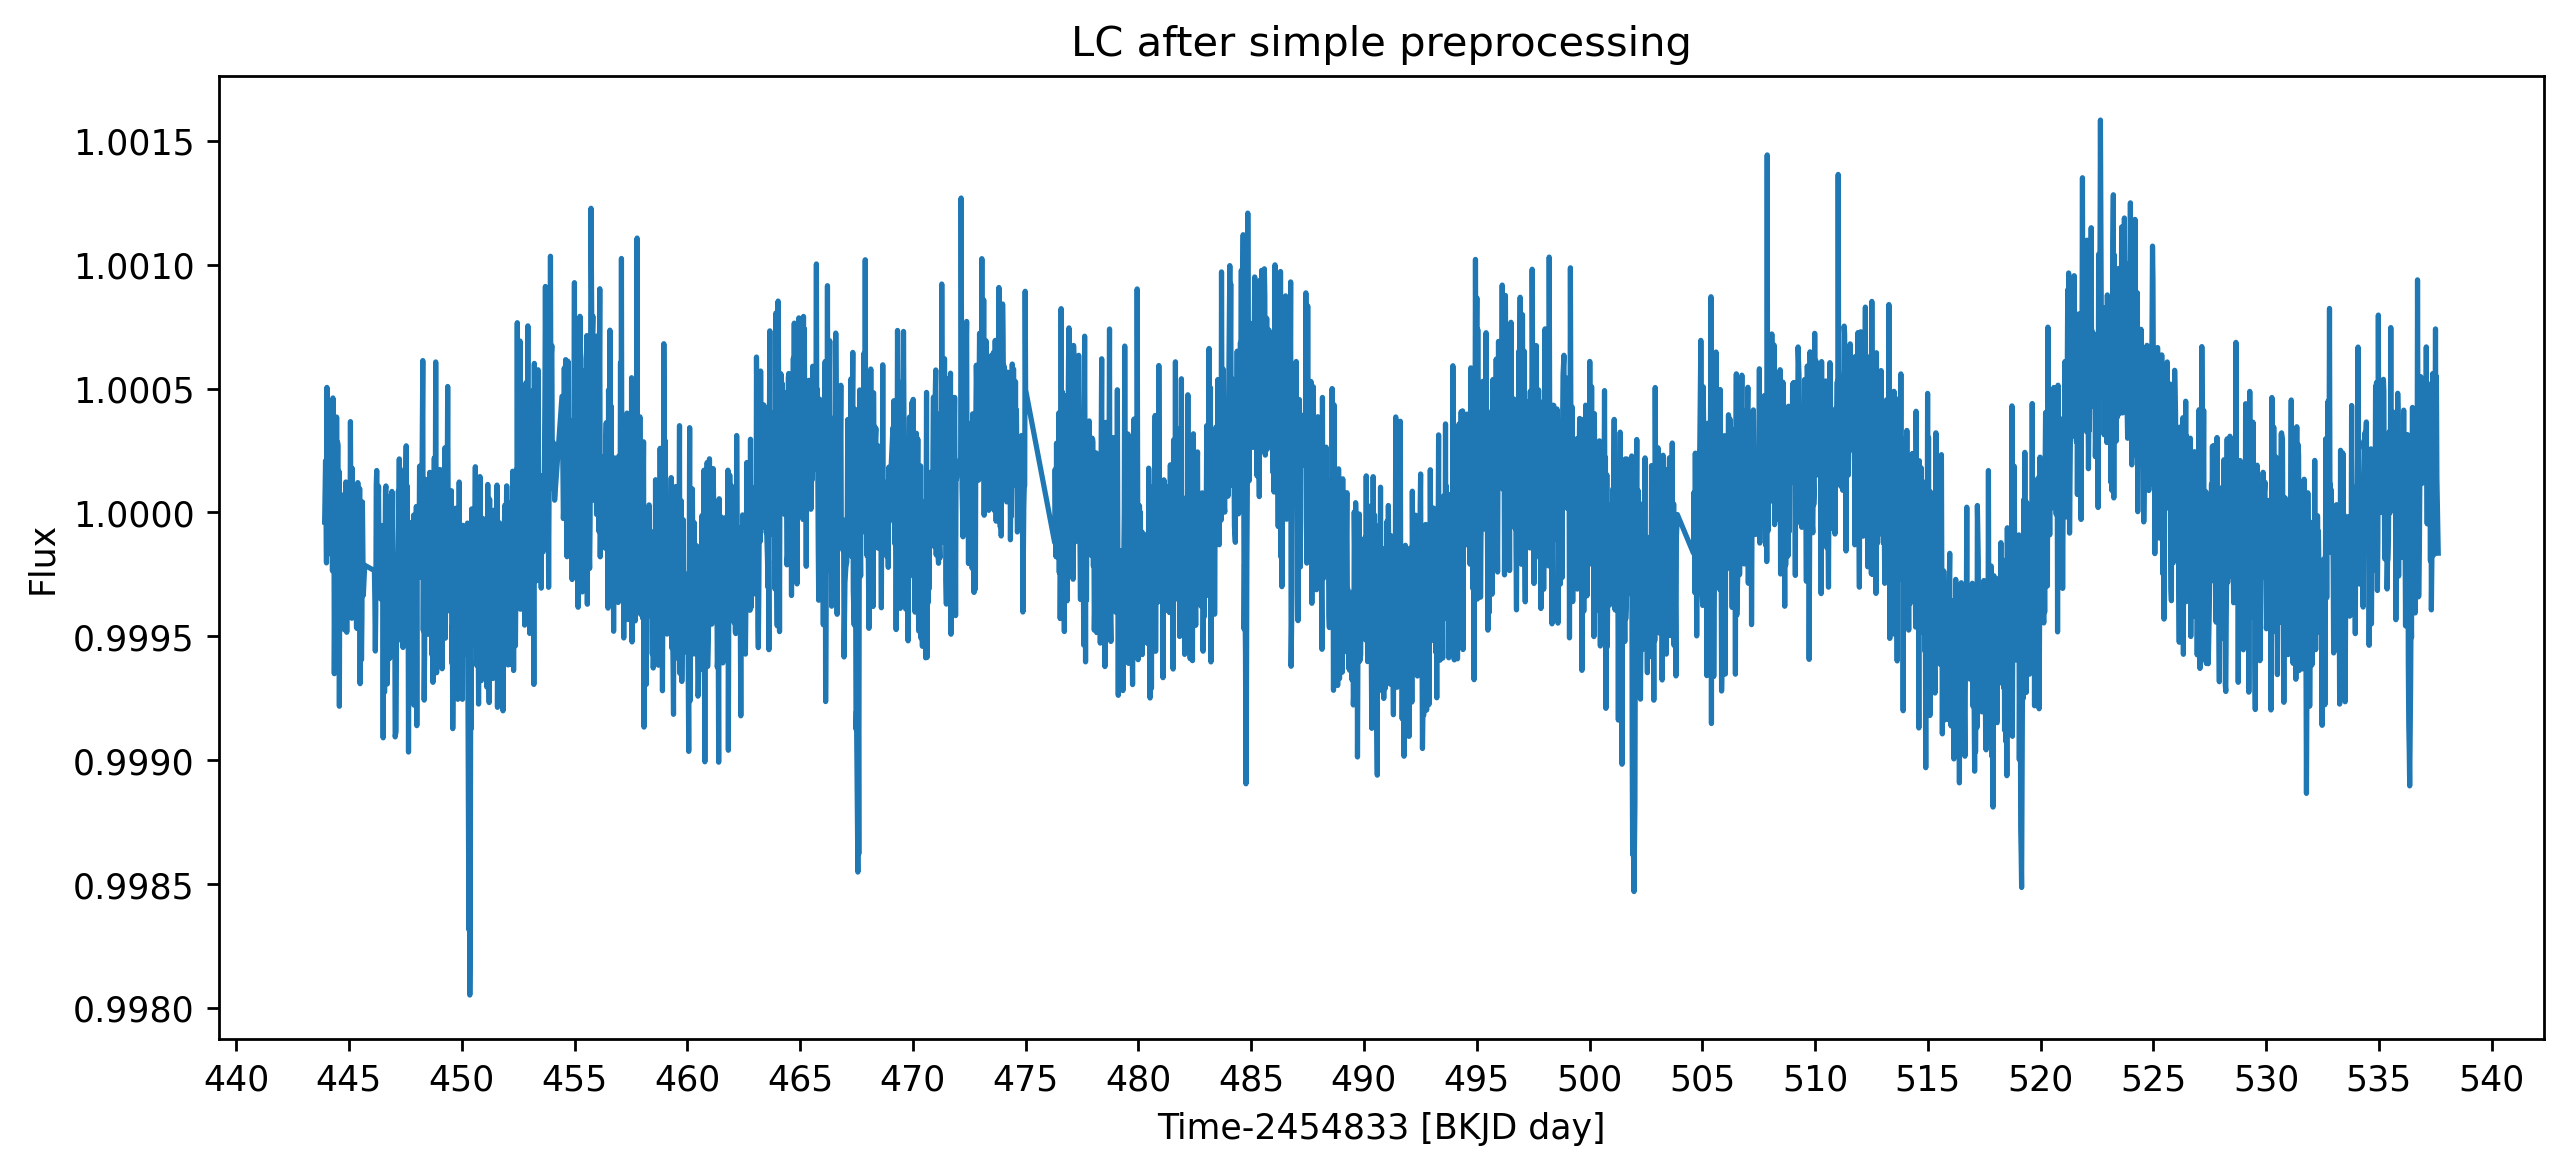

In [3]:
plt.figure(figsize=(12,5))
plt.plot(t,f)
plt.xlabel('Time-2454833 [BKJD day]')
plt.ylabel('Flux')
plt.title(f'LC after simple preprocessing')
plt.locator_params(axis='x', nbins=30)
plt.show()

### The SPLS algorithm consists of the following steps:
0. Segmentation
1. Linear search
2. Periodogram (including periodic search and global fitting)

### 0. Segmentation
**`step0_segment()`** is required.

**`step0_default_trend_order()`** is optional but recommended.     
The parameters **`dmax`** (maximum sampled transit duration) and **`window`** (window size) should be provided by the user.

The light curve is divided into 8 segments according to time gaps.
The light curve is further divided into 8 segments according to flux gaps.


/Users/shuyuezheng/anaconda3/lib/python3.10/site-packages/numba/core/utils.py:612: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  warnings.warn("First-class function type feature is experimental",


Default best trend order is 1 for 1210 segments in the model comparison.


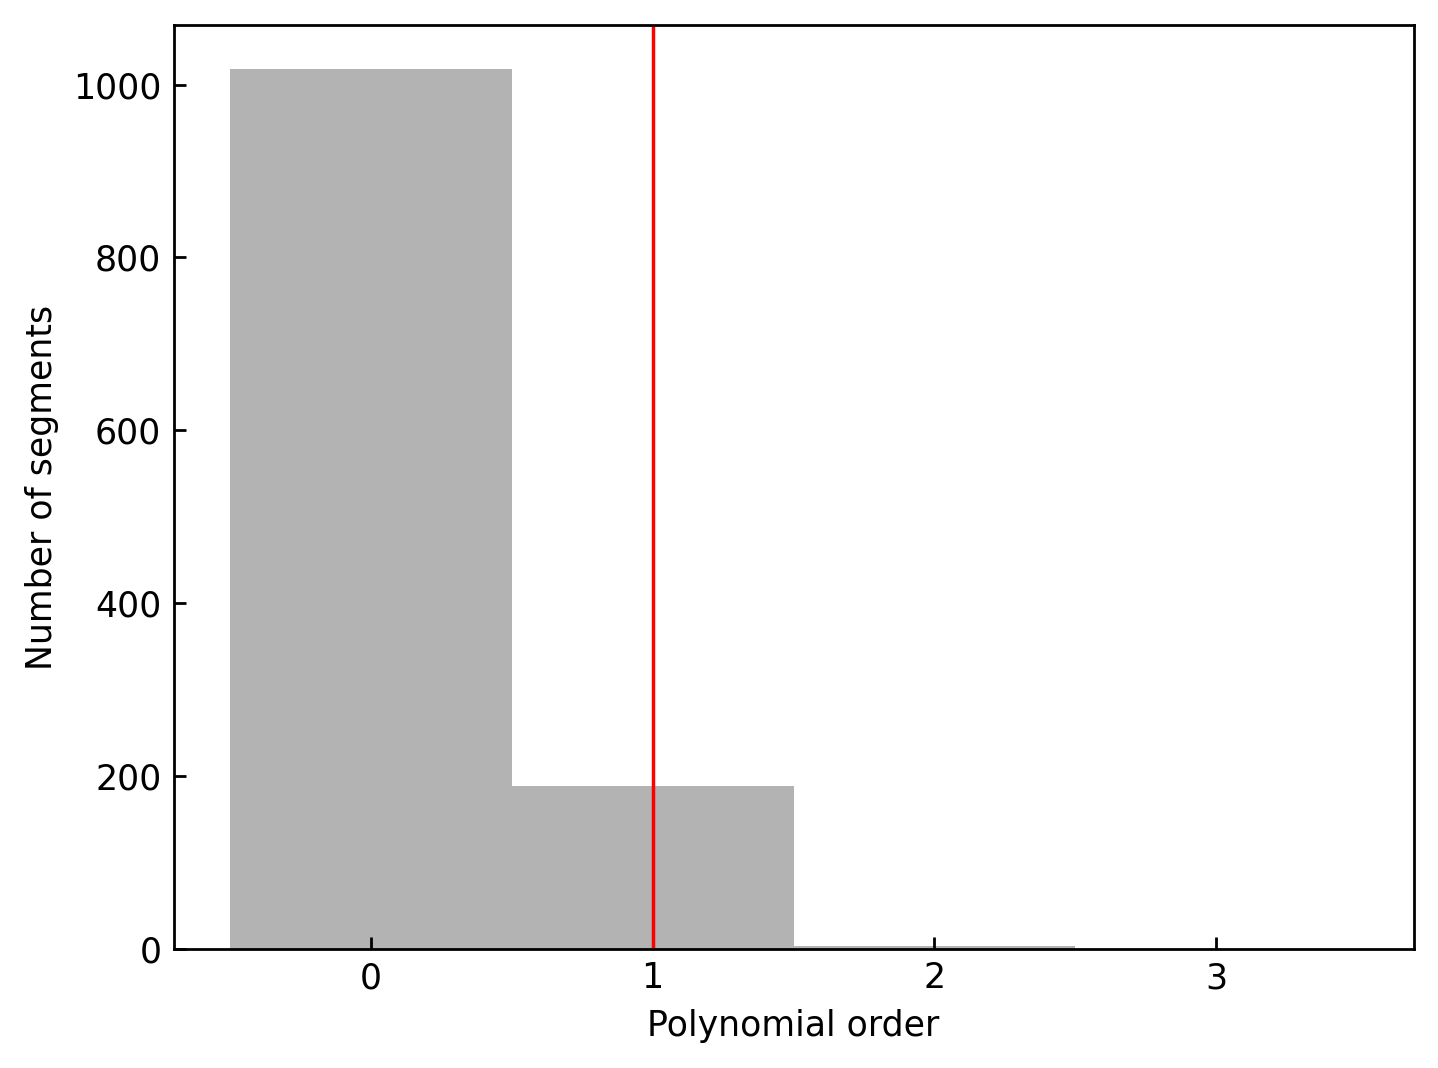

In [4]:
from SPLS import SPLeastSquares
SPsearch = SPLeastSquares(t,f,df)

# Segment the time series data based on time and flux gaps. 
SPsearch.step0_segment(flux_gap=True)
# Determine the default optimal polynomial order for the background trend component.
dmax = 0.9
window = 2*0.9
trend_order = SPsearch.step0_default_trend_order(dmax, window)

### 1. Linear search
**`step1_pre_default_dsam1()`** is optional but recommended.          
Besides `dmax`, the parameter **`sig_order`** (polynomial order for signal component) should be provided by the user. The fourth order is recommended.

**`step1_linear_search()`** is required.           
Besides `sig_order`, `trend_order`, `d_sam`, `window`, the following parameters should be provided here:            
- `max_workers`(The number of parallel workers to use) 
- `Pmin_step1` (The minimum sampled period (in days)) It must be no less than the window size.
  
Note: 
- If default period sampling is adopted, the parameters `Pmin_step1`, `OS_P`, `Rs`, `Ms` need to be considered. `dPmin` used in this case is the default value.
- if custom period sampling is used by the user, the parameters `Pmin_step1`, `dPmin` need to be considered. `dPmin` should be provided by the user.

In [5]:
# Default sampled transit durations
sig_order = 4
d_sam = SPsearch.step1_pre_default_dsam1(sig_order,dmax,OS_d=10)
# Linear search to construct a 2D log-likelihood difference map
max_workers = 7
Pmin_step1 = 6
result_linear = SPsearch.step1_linear_search(trend_order, sig_order, 
                                            d_sam, window,
                                            max_workers,
                                            Pmin_step1,
                                            OS_tm=3
                                            )

Sample 10 transit durations from 0.081735759741 day to 0.9 day.
Sample 21305 mid-transit times


/Users/shuyuezheng/anaconda3/lib/python3.10/site-packages/numba/core/utils.py:612: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  warnings.warn("First-class function type feature is experimental",
100%|██████████| 8/8 [00:05<00:00,  1.34it/s]


Linear search cost time 0.10982191562652588 min


In [6]:
vars(result_linear).keys()

dict_keys(['dlnL', 'tm_sam', 'd_sam'])

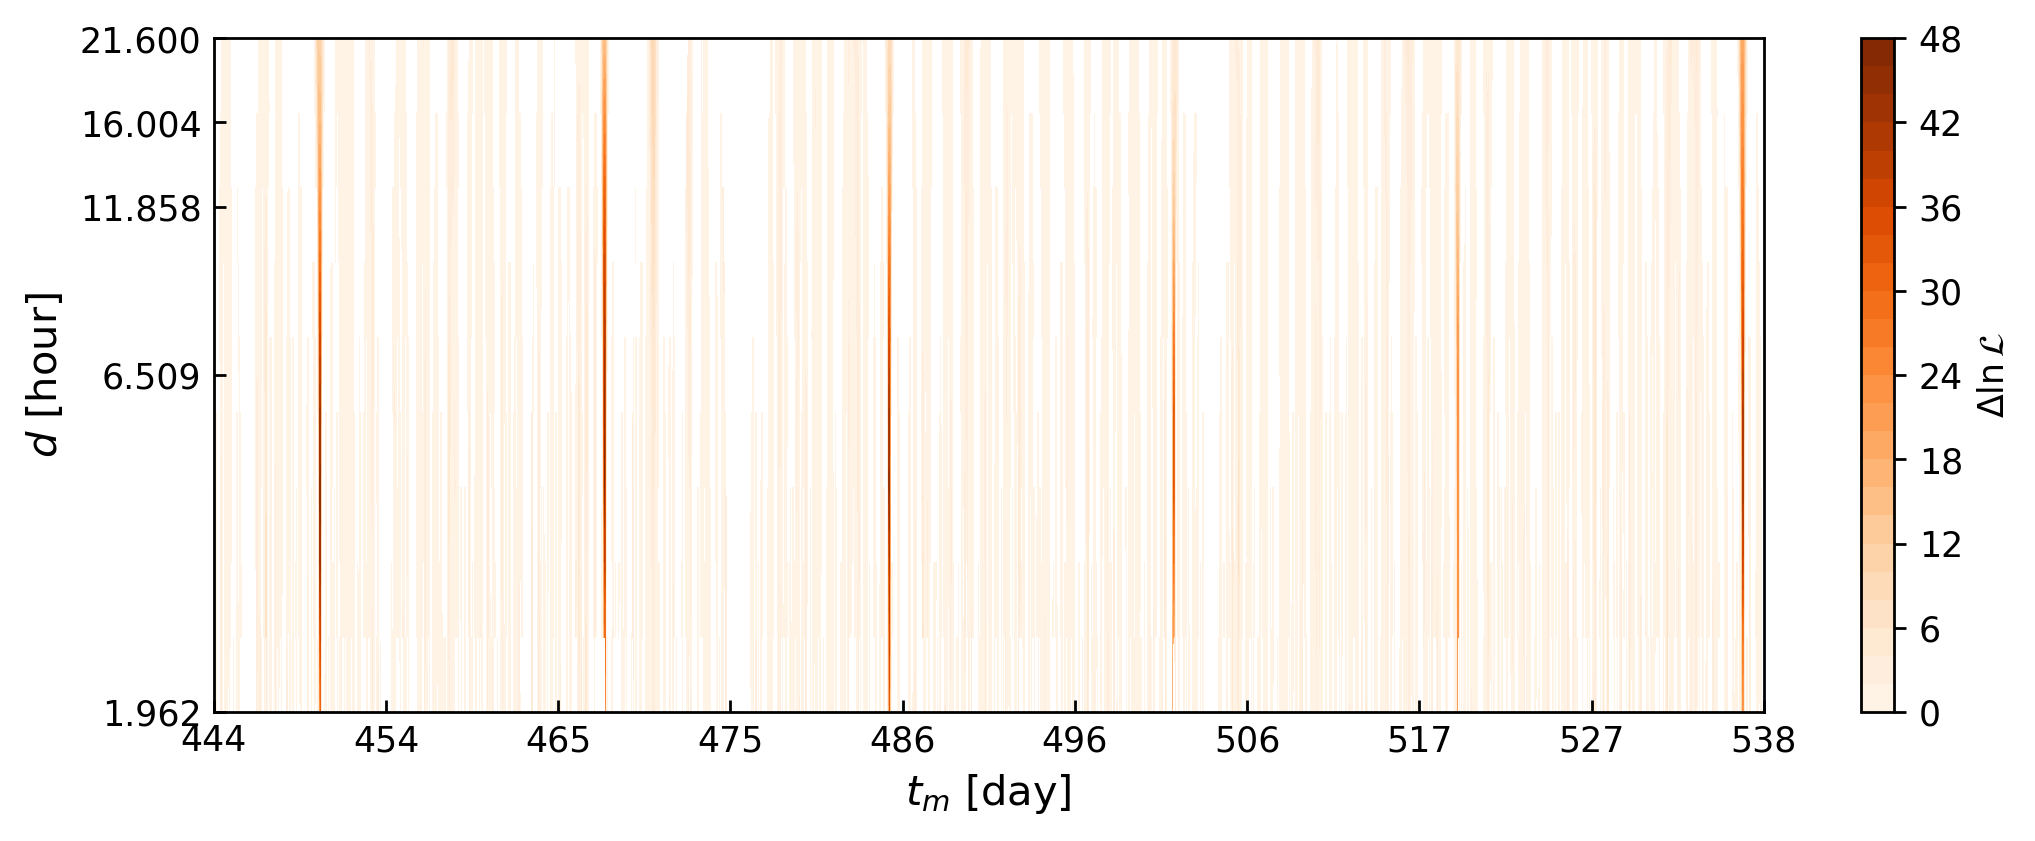

In [7]:
result_linear.plot()

### 2. Periodogram (including periodic search and global fitting)
**`step2_pre_default_Psam()`** is optional but recommended.       
Note that `Pmin_step2` (The minimum sampled period in this step) must be no less than `Pmin_step1`.   

**`step2_periodogram()`** is required.

Note:
- if the default period sampling is adopted, the value of `min_num_transit` must be same for `step2_pre_default_Psam()` and `step2_periodogram()`.
- This method also allows for both sequential and parallel computations. But sequential computation (`max_workers=1`) is recommended, because the parallel computation is often slower due to the large memory usage.

In [8]:
# Default sampled periods
min_num_transit=2
P_sam = SPsearch.step2_pre_default_Psam(Pmin_step2=6,min_num_transit=min_num_transit)
# periodic search and global fitting to construct a periodogram
result_periodogram = SPsearch.step2_periodogram(P_sam, min_num_transit)

/Users/shuyuezheng/anaconda3/lib/python3.10/site-packages/numba/core/utils.py:612: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  warnings.warn("First-class function type feature is experimental",


Sample 2030 periods from 6.002350979232123 day to 46.85560058827102 day.


100%|██████████| 2030/2030 [02:41<00:00, 12.58it/s]  


P_best 17.198924734530365 day
d_best 4.364154804253552 hours
tm0_best 450.3592935556476 day
SDE_best 17.73168358558885
Periodic search and global fitting cost time 2.692631236712138 min


In [9]:
vars(result_periodogram).keys()

dict_keys(['d_sam', 'P_sam', 'dlnL_arr', 'SDE_arr', 'P_best', 'd_best', 'tm0_best', 'SDE_best', 'number_segments_at_best_parameters', 'data_number_in_transits', 'data_number_in_segments', 'depth_best', 'depth_sigma_best', 'depth_snr', 't_cut_list', 'phase_cut_list', 'f_cut_list', 'model_t_cut_list', 'model_phase_cut_list', 'model_f_cut_list', 'phase_cut_sort', 'de_f_cut_sort', 'model_phase_cut_sort', 'model_de_f_cut_sort', 't', 'f'])

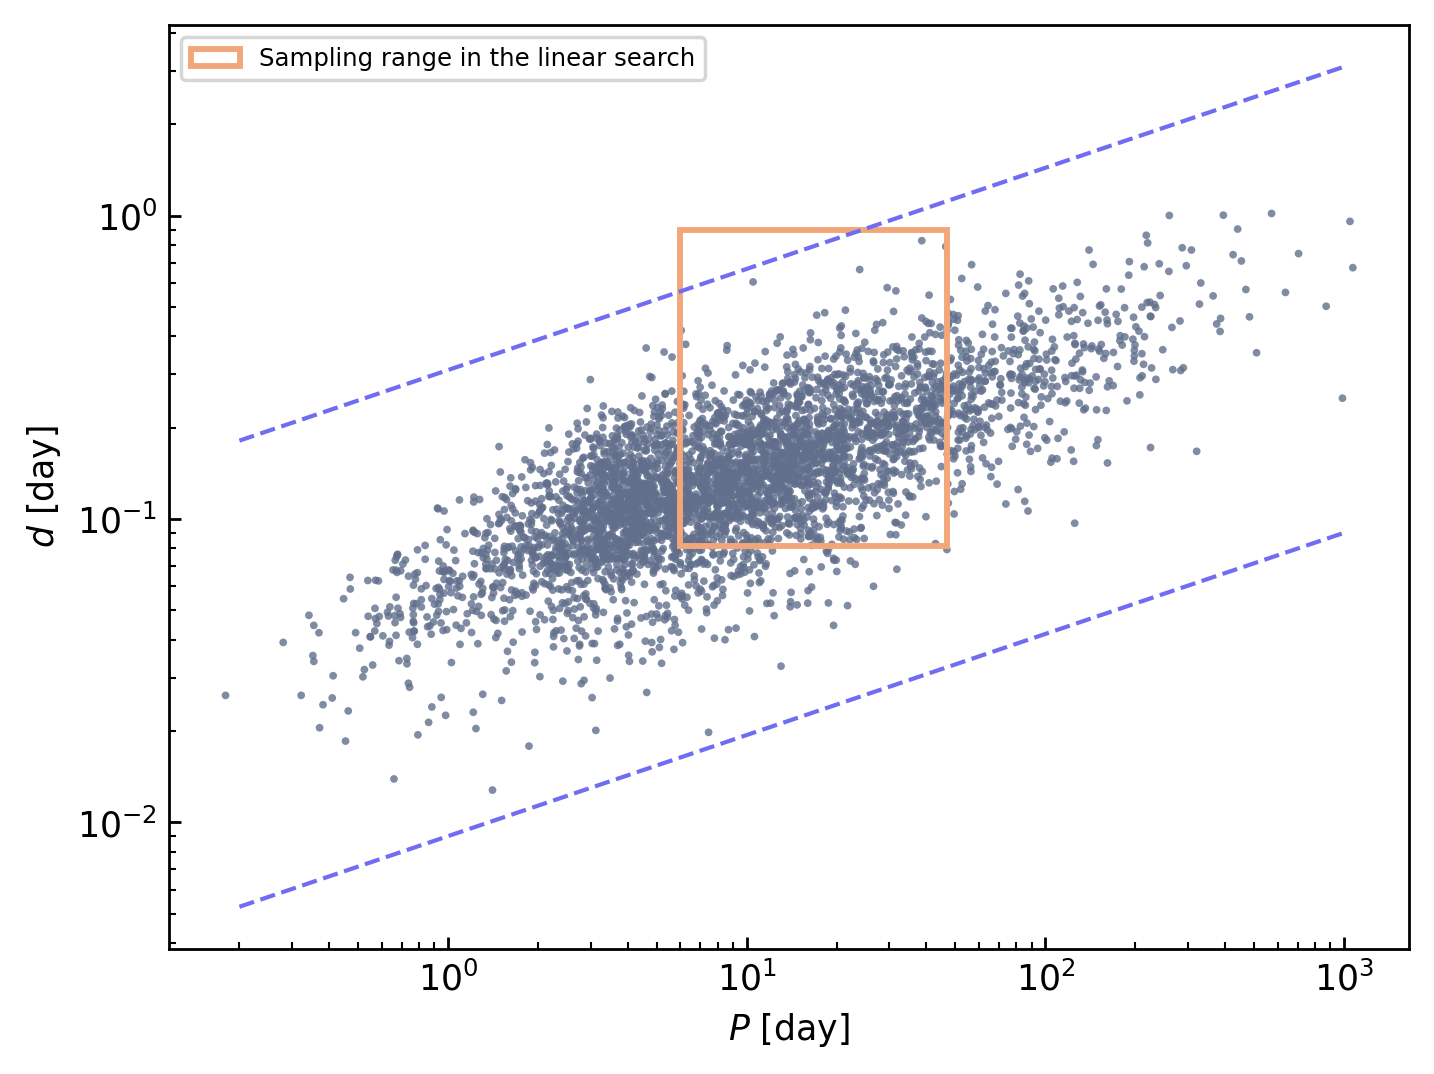

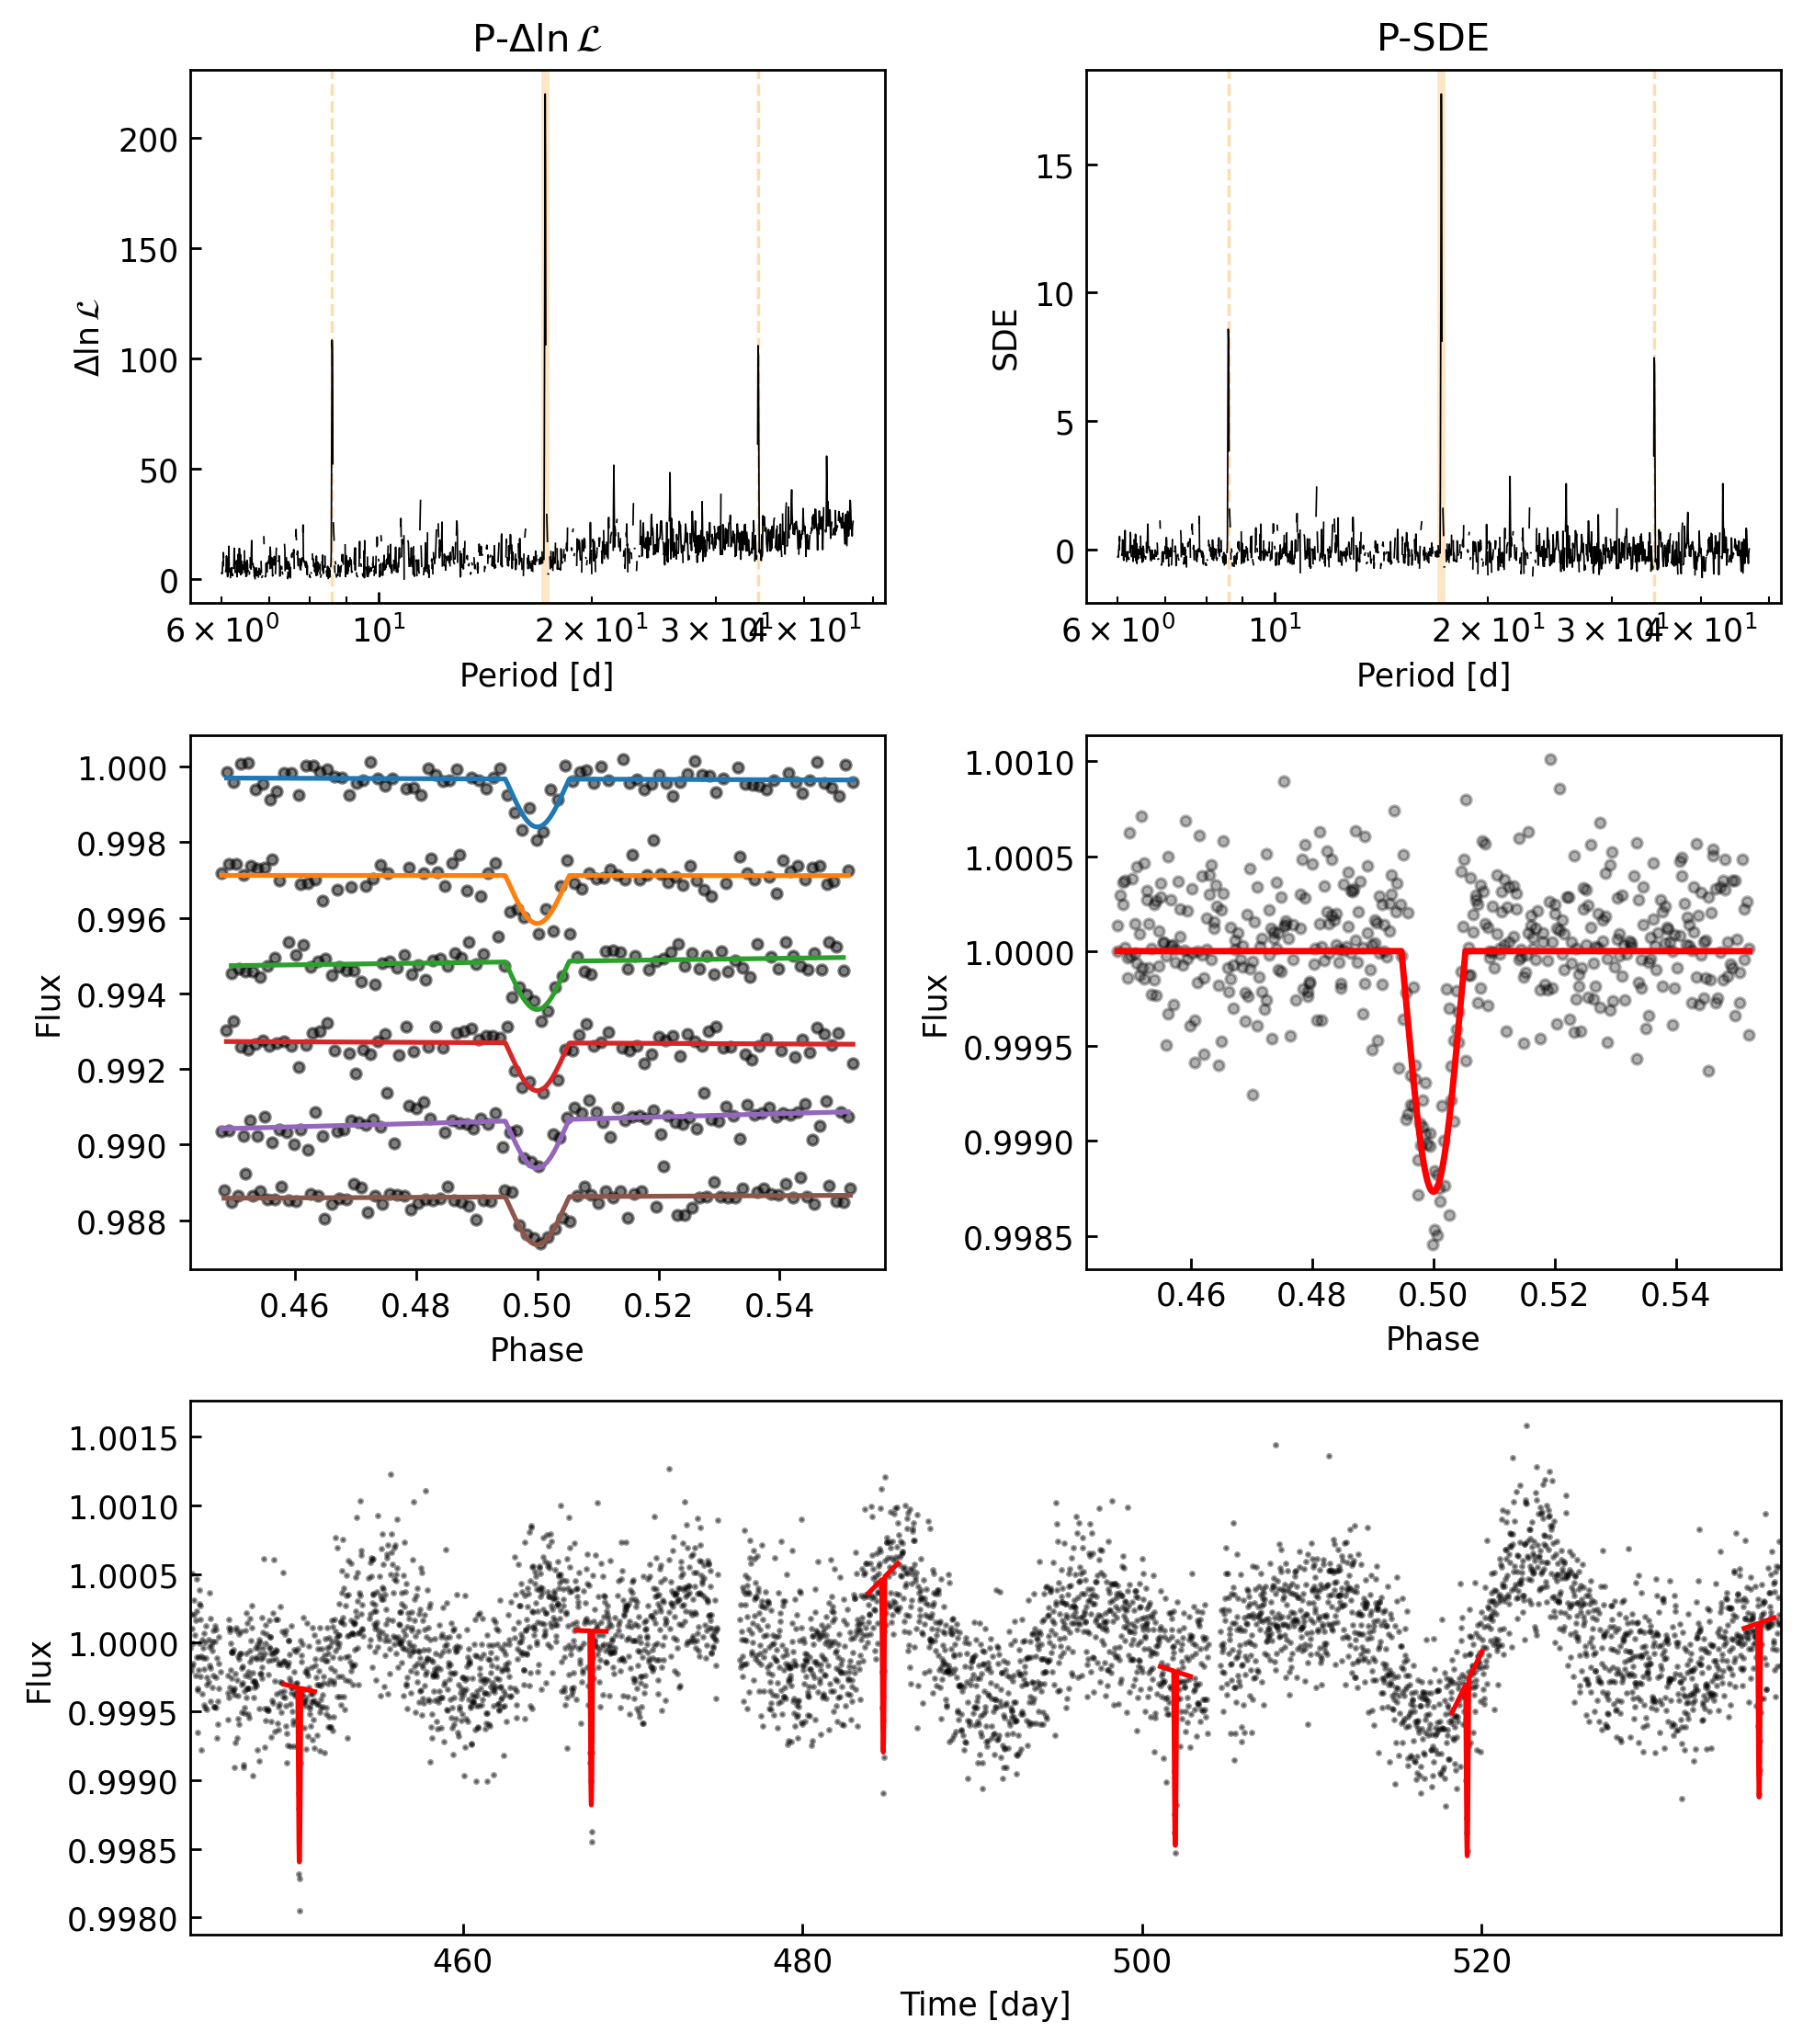

In [10]:
result_periodogram.plots()


The light curves only show the data within the windows used for fitting. The phase light curves on the left is vertically shifted for clarity and shows the simultaneous fitting of both background trends and the signal. The phase light curve and data on the right deliberately subtracts the fitted trend component from the periodic model.